# 1. Importing Libraries and Data

Importing the relevant libraries and the cleaned dataset.

In [1]:
import pandas as pd
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from IPython.display import display
from IPython.display import Image
from sklearn.externals.six import StringIO 
from subprocess import call

import warnings
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import StackingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
from pickle import dump

from Classes import Classification
from Classes import Ensemble

pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

/Users/ravimalde/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/data_cleaned6.csv')

The class distribution is checked to ensure that there is a balanced number of winners on both the fighter_x and fighter_y sides. This is already approximately a 50/50 split.

In [3]:
df.fx_win.value_counts(normalize=True)

1    0.500762
0    0.499238
Name: fx_win, dtype: float64

In [4]:
df.head()

,name_x,height_x,weight_x,reach_x,fx_win,age_x,height_x.1,weight_x.1,reach_x.1,str_landed_per_min_x,str_acc_x,str_absorb_per_min_x,str_def_x,td_avg_x,td_acc_x,td_def_x,sub_avg_x,win_percentage_x,name_y,height_y,weight_y,reach_y,age_y,height_y.1,weight_y.1,reach_y.1,str_landed_per_min_y,str_acc_y,str_absorb_per_min_y,str_def_y,td_avg_y,td_acc_y,td_def_y,sub_avg_y,win_percentage_y,stance_x_Open Stance,stance_x_Orthodox,stance_x_Sideways,stance_x_Southpaw,stance_x_Switch,stance_y_Open Stance,stance_y_Orthodox,stance_y_Sideways,stance_y_Southpaw,stance_y_Switch
0,Aaron Phillips,1.75,135.0,1.78,0,25.05,1.75,135.0,1.78,7.27,0.80,6.33,0.74,0.00,0.00,0.62,1.00,0.89,Matt Hobar,1.78,135.0,1.78,27.63,1.78,135.0,1.78,2.52,0.26,9.71,0.59,0.00,0.0,1.0,0.00,0.80,0,0,0,1,0,0,0,0,1,0
1,Aaron Riley,1.73,155.0,1.75,0,25.10,1.73,155.0,1.75,6.20,0.55,5.80,0.49,0.00,0.00,0.75,1.00,0.72,Spencer Fisher,1.70,155.0,1.78,29.69,1.70,155.0,1.78,2.26,0.48,8.64,0.62,1.54,0.5,1.0,4.63,0.85,0,0,0,1,0,0,0,0,1,0
2,Aaron Riley,1.73,155.0,1.75,1,27.93,1.73,155.0,1.75,5.50,0.54,5.85,0.48,1.50,0.29,0.75,0.75,0.70,Jorge Gurgel,1.70,155.0,1.75,31.81,1.70,155.0,1.75,5.80,0.50,5.80,0.50,1.00,0.5,0.5,0.00,0.64,0,0,0,1,0,0,1,0,0,0
3,Aaron Riley,1.73,155.0,1.75,1,28.66,1.73,155.0,1.75,6.91,0.52,5.96,0.45,1.26,0.38,0.58,0.42,0.69,Shane Nelson,1.75,155.0,1.78,24.69,1.75,155.0,1.78,6.85,0.42,6.85,0.42,0.00,0.0,0.0,0.00,0.78,0,0,0,1,0,0,0,0,1,0
4,Aaron Riley,1.73,155.0,1.75,1,29.47,1.73,155.0,1.75,7.68,0.53,6.10,0.50,1.11,0.38,0.11,0.00,0.68,Joe Brammer,1.73,155.0,1.73,26.77,1.73,155.0,1.73,1.39,0.24,4.17,0.58,0.00,0.0,1.0,0.00,0.70,0,0,0,1,0,0,1,0,0,0


# 2. Data Transformations

In this section the data is transformed using the StandardScaler class. The scaling was fit to fighter_x and then used to transform the fighter_y data.

In [5]:
y = df[['fx_win']]

In [6]:
X = df.drop(columns=['fx_win','name_x','name_y'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=400, random_state=50, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=50, stratify=y_train)

In [8]:
x_num_cols = [col for col in X.columns if '_x' in col and 'stance' not in col]
y_num_cols = [col for col in X.columns if '_y' in col and 'stance' not in col]

In [9]:
scaler = RobustScaler()

In [10]:
X_train[x_num_cols] = scaler.fit_transform(X_train[x_num_cols])
X_train[y_num_cols] = scaler.transform(X_train[y_num_cols])

X_val[x_num_cols] = scaler.transform(X_val[x_num_cols])
X_val[y_num_cols] = scaler.transform(X_val[y_num_cols])

X_test[x_num_cols] = scaler.transform(X_test[x_num_cols])
X_test[y_num_cols] = scaler.transform(X_test[y_num_cols])

The scaler was then saved to be used on the data in the web application.

In [11]:
dump(scaler, open('scaler.pkl', 'wb'))

# 3. Modelling

A stratified kfold with 5 splits was used for the cross validation of the models.

In [12]:
skf = StratifiedKFold(n_splits=5, random_state=50)

## 3.1. Logistic Regression

The first model tried was a logistic regression. This acts as a baseline for which other models will be compared to. The metric by which models will be assessed is the area under the ROC curve.

In [13]:
log_reg1 = Classification("Logistic Regression", X_train, X_val, y_train, y_val)

A grid search is completed which returns the best performing hyperparameters for the model.

,Model,Train AUC,Validation AUC
0,Logistic Regression,0.660853,0.65795


The best hyperparameters are:  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'} 



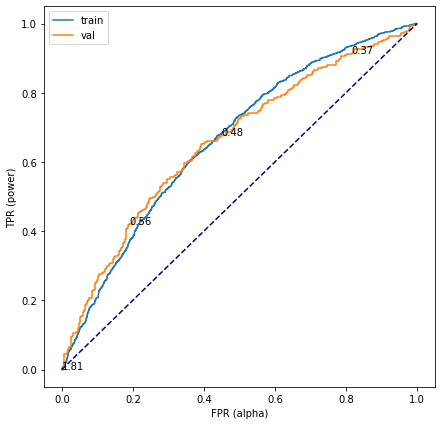

In [14]:
param_grid = {'C': [0.01,0.1,1,10,100],
             'penalty': ['l1','l2'],
             'solver': ['liblinear','saga']}
log_reg1.get_scores(param_grid, skf)

## 3.2. Support Vector Machine

In [15]:
svm1 = Classification("SVM", X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,SVM,0.8125,0.692503


The best hyperparameters are:  {'C': 1, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale'} 



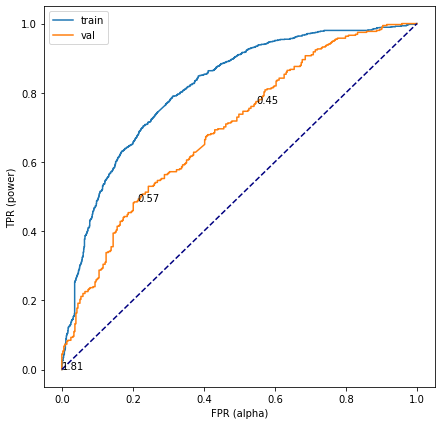

In [16]:
param_grid = {'C':[1,2,3,4,5,6],
             'degree':[1,2,3,4,5,6],
             'gamma':['scale','auto'],
             'decision_function_shape':['ovo','ovr']}
svm1.get_scores(param_grid, skf)

## 3.3. Decision Tree

In [17]:
d_tree1 = Classification('Decision Tree', X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Decision Tree,0.828566,0.605191


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 10} 



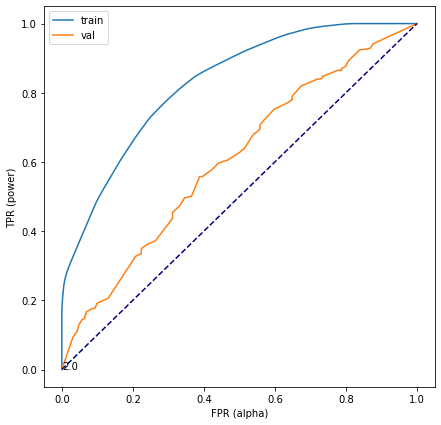

In [18]:
param_grid = {'max_depth':[1,10,100,1000],'min_samples_leaf':[1,10,100,1000]}
d_tree1.get_scores(param_grid, skf)

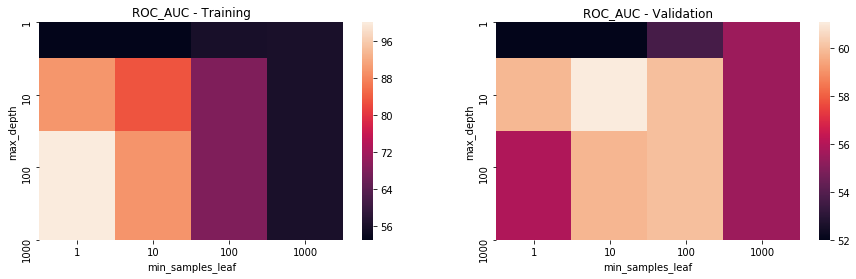

In [19]:
d_tree1.opt_plots()

In [20]:
d_tree2 = Classification('Decision Tree', X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Decision Tree,0.765262,0.618669


The best hyperparameters are:  {'max_depth': 8, 'min_samples_leaf': 18} 



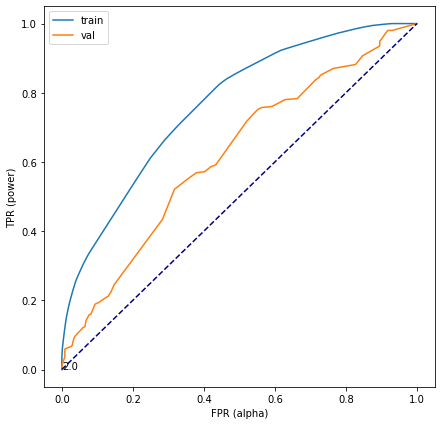

In [21]:
param_grid = {'max_depth':range(1,20,1),'min_samples_leaf':range(1,30,1)}
d_tree2.get_scores(param_grid, skf)

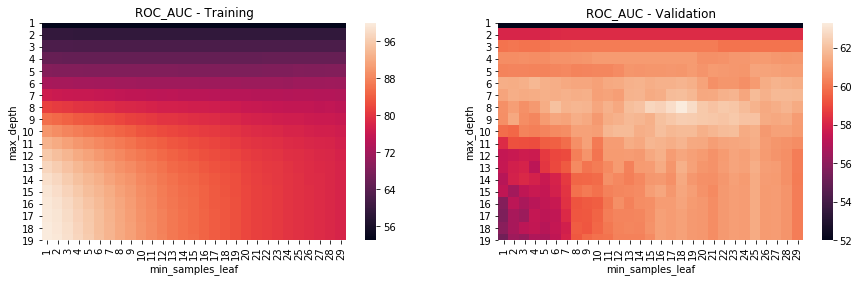

In [22]:
d_tree2.opt_plots()

## 3.4. Random Forest

In [23]:
rand_forr1 = Classification("Random Forest", X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Random Forest,0.993514,0.709731


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 1} 



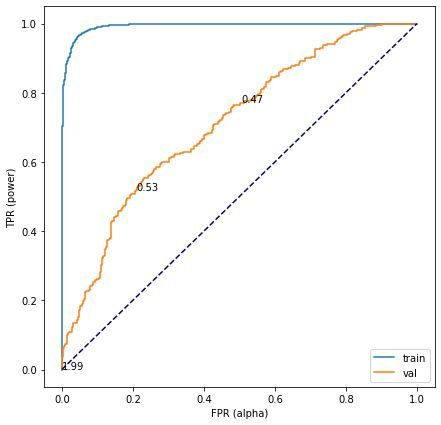

In [24]:
param_grid = {'max_depth':[1,10,100,1000],'min_samples_leaf':[1,10,100,1000]}
rand_forr1.get_scores(param_grid, skf)

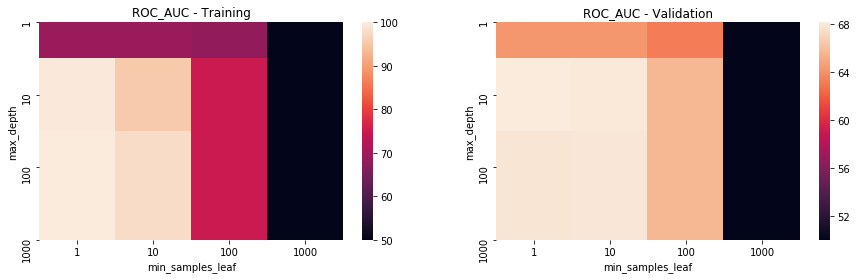

In [25]:
rand_forr1.opt_plots()

In [26]:
rand_forr2 = Classification("Random Forest", X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Random Forest,0.991977,0.705031


The best hyperparameters are:  {'max_depth': 11, 'min_samples_leaf': 4} 



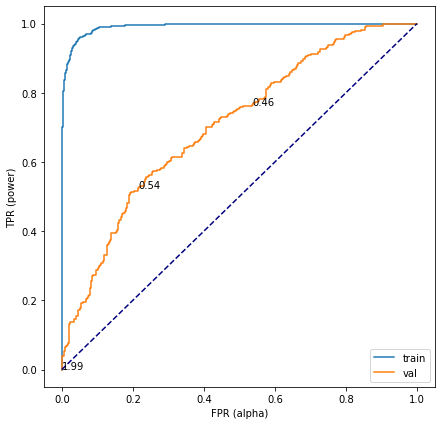

In [28]:
param_grid = {'max_depth':range(1,31,1),'min_samples_leaf':range(1,16,1)}
rand_forr2.get_scores(param_grid, skf)

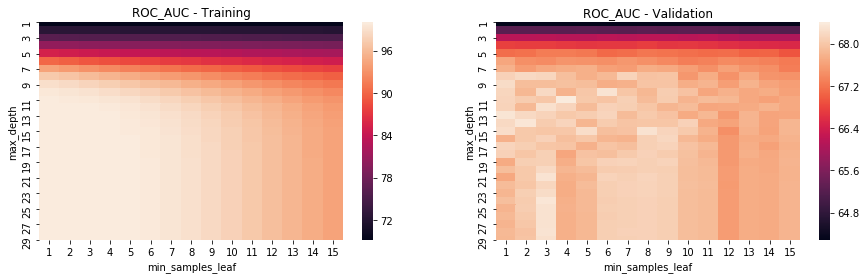

In [29]:
rand_forr2.opt_plots()

## 3.5. Voing Classifier

In [30]:
svm = ('svm', svm1.best_model)
rand_forr = ('rand_forr', rand_forr2.best_model)
estimators = [svm, rand_forr]
voting = Ensemble("Voting", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Voting,0.933463,0.705295


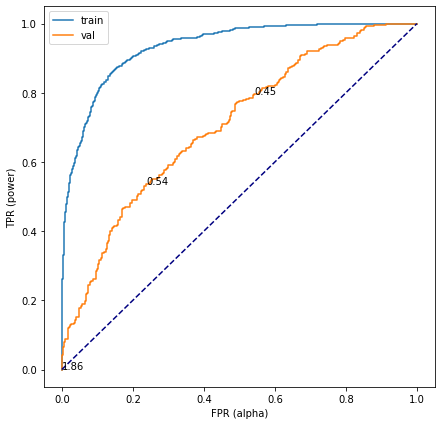

In [31]:
voting.ensemble_get_scores({}, skf)

## 3.6. Adaboost

In [34]:
estimators = rand_forr2.best_model
adaboost = Ensemble("AdaBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,AdaBoost,1.0,0.663891


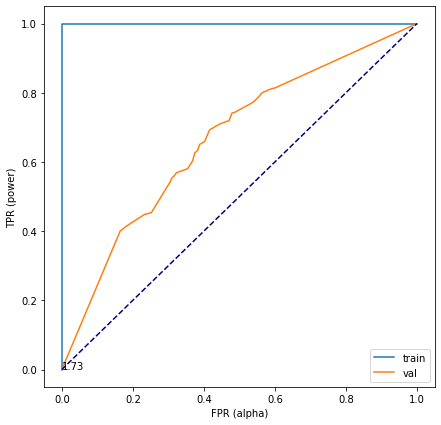

In [35]:
adaboost.ensemble_get_scores({}, skf)

## 3.7. XGBoost

In [36]:
estimators = []
xgboost = Ensemble("XGBoost", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,XGBoost,0.842878,0.69591


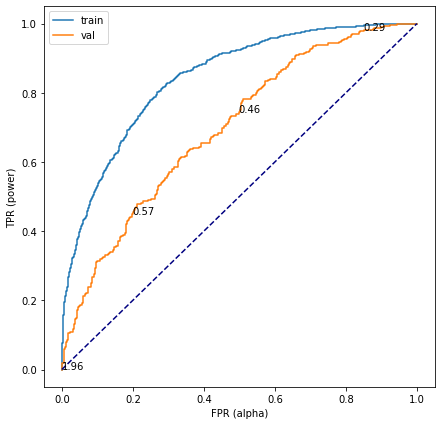

In [37]:
xgboost.ensemble_get_scores({}, skf)

## 3.8. Stacking Classifier

In [192]:
estimators = [('svm', svm1.best_model), 
              ('rnd', rand_forr2.best_model),
              ('voting', voting.best_model)]
stacking = Ensemble("Stacking", estimators, X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Stacking,0.980982,0.70713


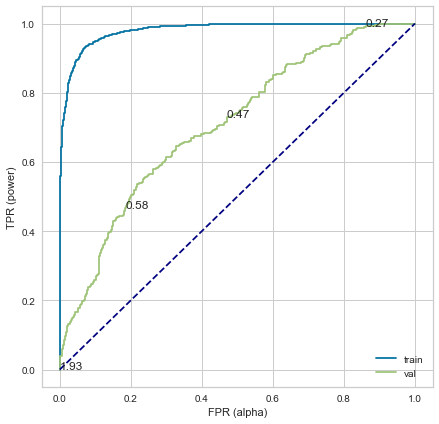

In [193]:
stacking.ensemble_get_scores({}, skf)

## 3.9. Deep Neural Network

In [161]:
l2_reg = keras.regularizers.l2(0.0001)

In [162]:
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_dim=X_train.shape[1], kernel_initializer='normal', 
                 kernel_regularizer=l2_reg))
model1.add(Dropout(rate=0.1))
model1.add(Dense(64, activation='relu', kernel_initializer='normal', kernel_regularizer=l2_reg))
model1.add(Dropout(rate=0.1))
model1.add(Dense(1, activation='sigmoid'))

In [163]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                2752      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 6,977
Trainable params: 6,977
Non-trainable params: 0
_________________________________________________________________


In [164]:
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [165]:
history = model1.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

Train on 2828 samples, validate on 708 samples
Epoch 1/20
2828/2828 [==============================] - 1s 460us/step - loss: 0.6806 - accuracy: 0.5753 - val_loss: 0.6703 - val_accuracy: 0.5904
Epoch 2/20
2828/2828 [==============================] - 0s 148us/step - loss: 0.6541 - accuracy: 0.6167 - val_loss: 0.6480 - val_accuracy: 0.6073
Epoch 3/20
2828/2828 [==============================] - 0s 147us/step - loss: 0.6427 - accuracy: 0.6333 - val_loss: 0.6474 - val_accuracy: 0.6172
Epoch 4/20
2828/2828 [==============================] - 0s 149us/step - loss: 0.6326 - accuracy: 0.6400 - val_loss: 0.6489 - val_accuracy: 0.6201
Epoch 5/20
2828/2828 [==============================] - 0s 142us/step - loss: 0.6234 - accuracy: 0.6513 - val_loss: 0.6530 - val_accuracy: 0.6285
Epoch 6/20
2828/2828 [==============================] - 0s 148us/step - loss: 0.6199 - accuracy: 0.6591 - val_loss: 0.6481 - val_accuracy: 0.6088
Epoch 7/20
2828/2828 [==============================] - 0s 148us/step - loss:

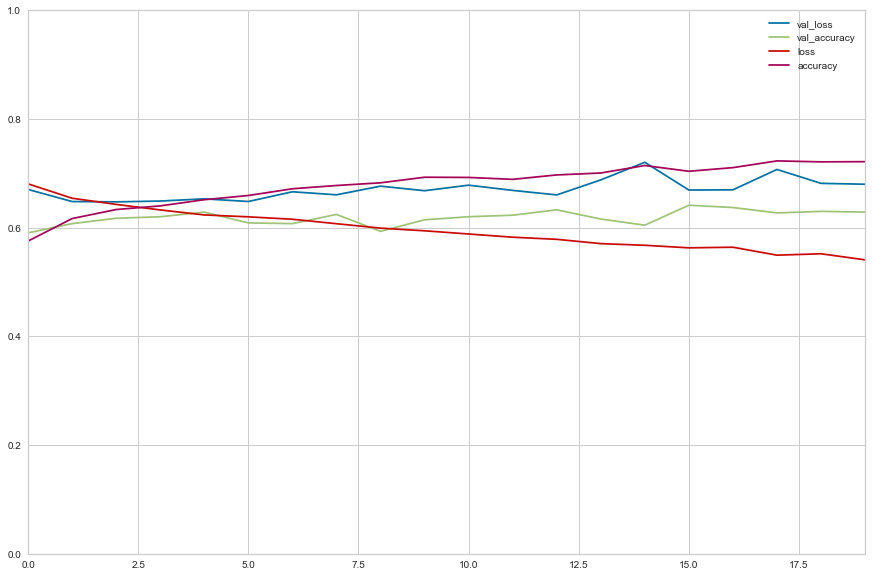

In [166]:
pd.DataFrame(history.history).plot(figsize=(15,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [170]:
nn_val_accuracy = model1.evaluate(X_val, y_val)[1]

708/708 [==============================] - 0s 40us/step


# 4. Model Evaluation

In [176]:
model_roc_auc_list = [log_reg1.scores_table,
                         svm1.scores_table, 
                         d_tree2.scores_table, 
                         rand_forr2.scores_table,
                         voting.scores_table,
                         adaboost.scores_table,
                         xgboost.scores_table,
                         stacking.scores_table]

In [177]:
df_evaluation = pd.concat(model_roc_auc_list)

In [178]:
model_val_score = [log_reg1.best_model.score(X_val, y_val),
                    svm1.best_model.score(X_val, y_val),
                    d_tree2.best_model.score(X_val, y_val), 
                    rand_forr2.best_model.score(X_val, y_val),
                    voting.best_model.score(X_val, y_val),
                    adaboost.best_model.score(X_val, y_val),
                    xgboost.best_model.score(X_val, y_val),
                    stacking.best_model.score(X_val, y_val)]

In [179]:
df_evaluation['Validation Accuracy'] = model_val_score

In [180]:
df_nn = {'Model':'Deep Neural Network','Train AUC':'Unknown','Validation AUC':'Unknown','Validation Accuracy':nn_val_accuracy}

In [181]:
df_evaluation = df_evaluation.append(df_nn, ignore_index=True)

In [182]:
df_evaluation.sort_values(by='Validation Accuracy', ascending=False, inplace=True)
df_evaluation.reset_index(drop=True, inplace=True)

In [183]:
df_evaluation

,Model,Train AUC,Validation AUC,Validation Accuracy
0,Stacking,0.980982,0.70713,0.659605
1,Voting,0.933463,0.705295,0.642655
2,Random Forest,0.991977,0.705031,0.641243
3,AdaBoost,1,0.663891,0.631356
4,SVM,0.8125,0.692503,0.629944
5,Deep Neural Network,Unknown,Unknown,0.628531
6,XGBoost,0.842878,0.69591,0.628531
7,Logistic Regression,0.660853,0.65795,0.622881
8,Decision Tree,0.765262,0.618669,0.598870


In [94]:
dump(stacking.best_model, open('model.pkl', 'wb'))

In [95]:
stacking.best_model.score(X_test, y_test)

0.64

# 5. Feature Importance

In [135]:
df_importance = pd.DataFrame()

In [136]:
df_importance['Feature'] = X_train.columns

In [137]:
df_importance['Importance'] = rand_forr2.best_model.feature_importances_

In [139]:
df_importance.sort_values(by='Importance', ascending=False, inplace=True)

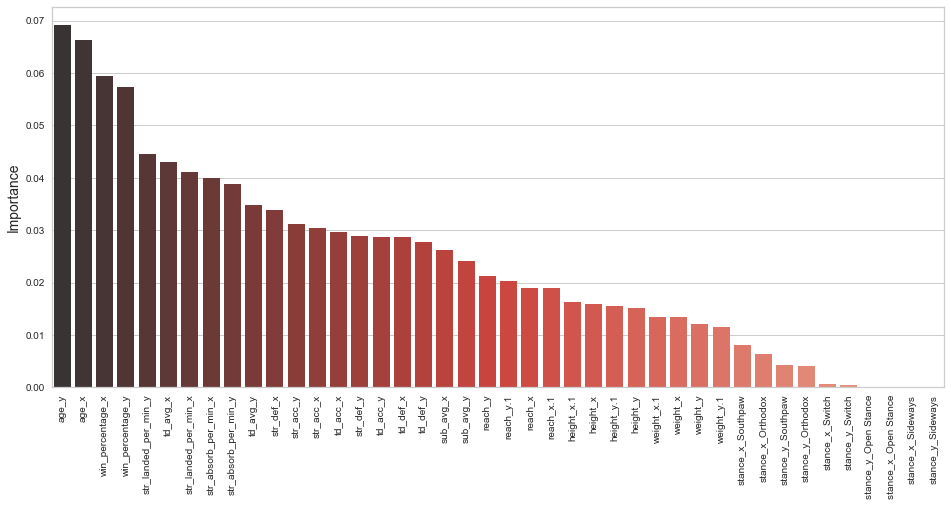

In [151]:
plt.figure(figsize=(16,7))
sns.barplot(x='Feature', y='Importance', data=df_importance, palette="Reds_d")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel('Importance', fontsize=14)
plt.show()